## BÀI TẬP LỚN MÔN HỌC MÁY

**Quora Insincere Question Classification**

Lớp: INT3405E_20

Họ và tên: Nguyễn Đức Huy

MSSV: 19021299

## Giới thiệu bài toán

Quora là một mạng xã hội trực tuyến nơi tất cả mọi người được phép đăng tải câu hỏi và nhận câu trả lời tương ứng, là nơi để mọi người có thể cùng trao đổi và chia sẻ kiến thức.

Vì Quora là một nơi dành cho tất cả mọi người nên không thể tránh khỏi các câu hỏi không có chất lượng hay thậm chí là mang tính tiêu cực, không tốt đẹp. Những câu hỏi đó được cho là không chân thành (Insincere). Chúng có đặc điểm là chỉ đưa ra những định kiến của bản thân mà không có mục đích là đi tìm câu trả lời.

Bài toán đặt ra là ta cần phân loại được đâu là những câu hỏi chân thành (Sincere) và không chân thành (Insincere).

### Dữ liệu được cung cấp

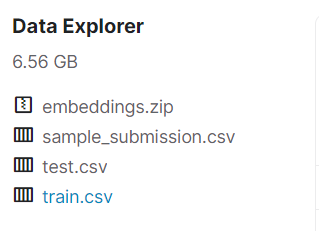

### Đánh giá: F1 Score

F1 Score dùng làm tiêu chí đánh giá cho bài toán. F1 Score có thể đo sự cân bằng giữa precision và recall.

$$ F1 = \frac {2 * \text{precision} * \text{recall}} {\text{precision} + \text{recall}} $$

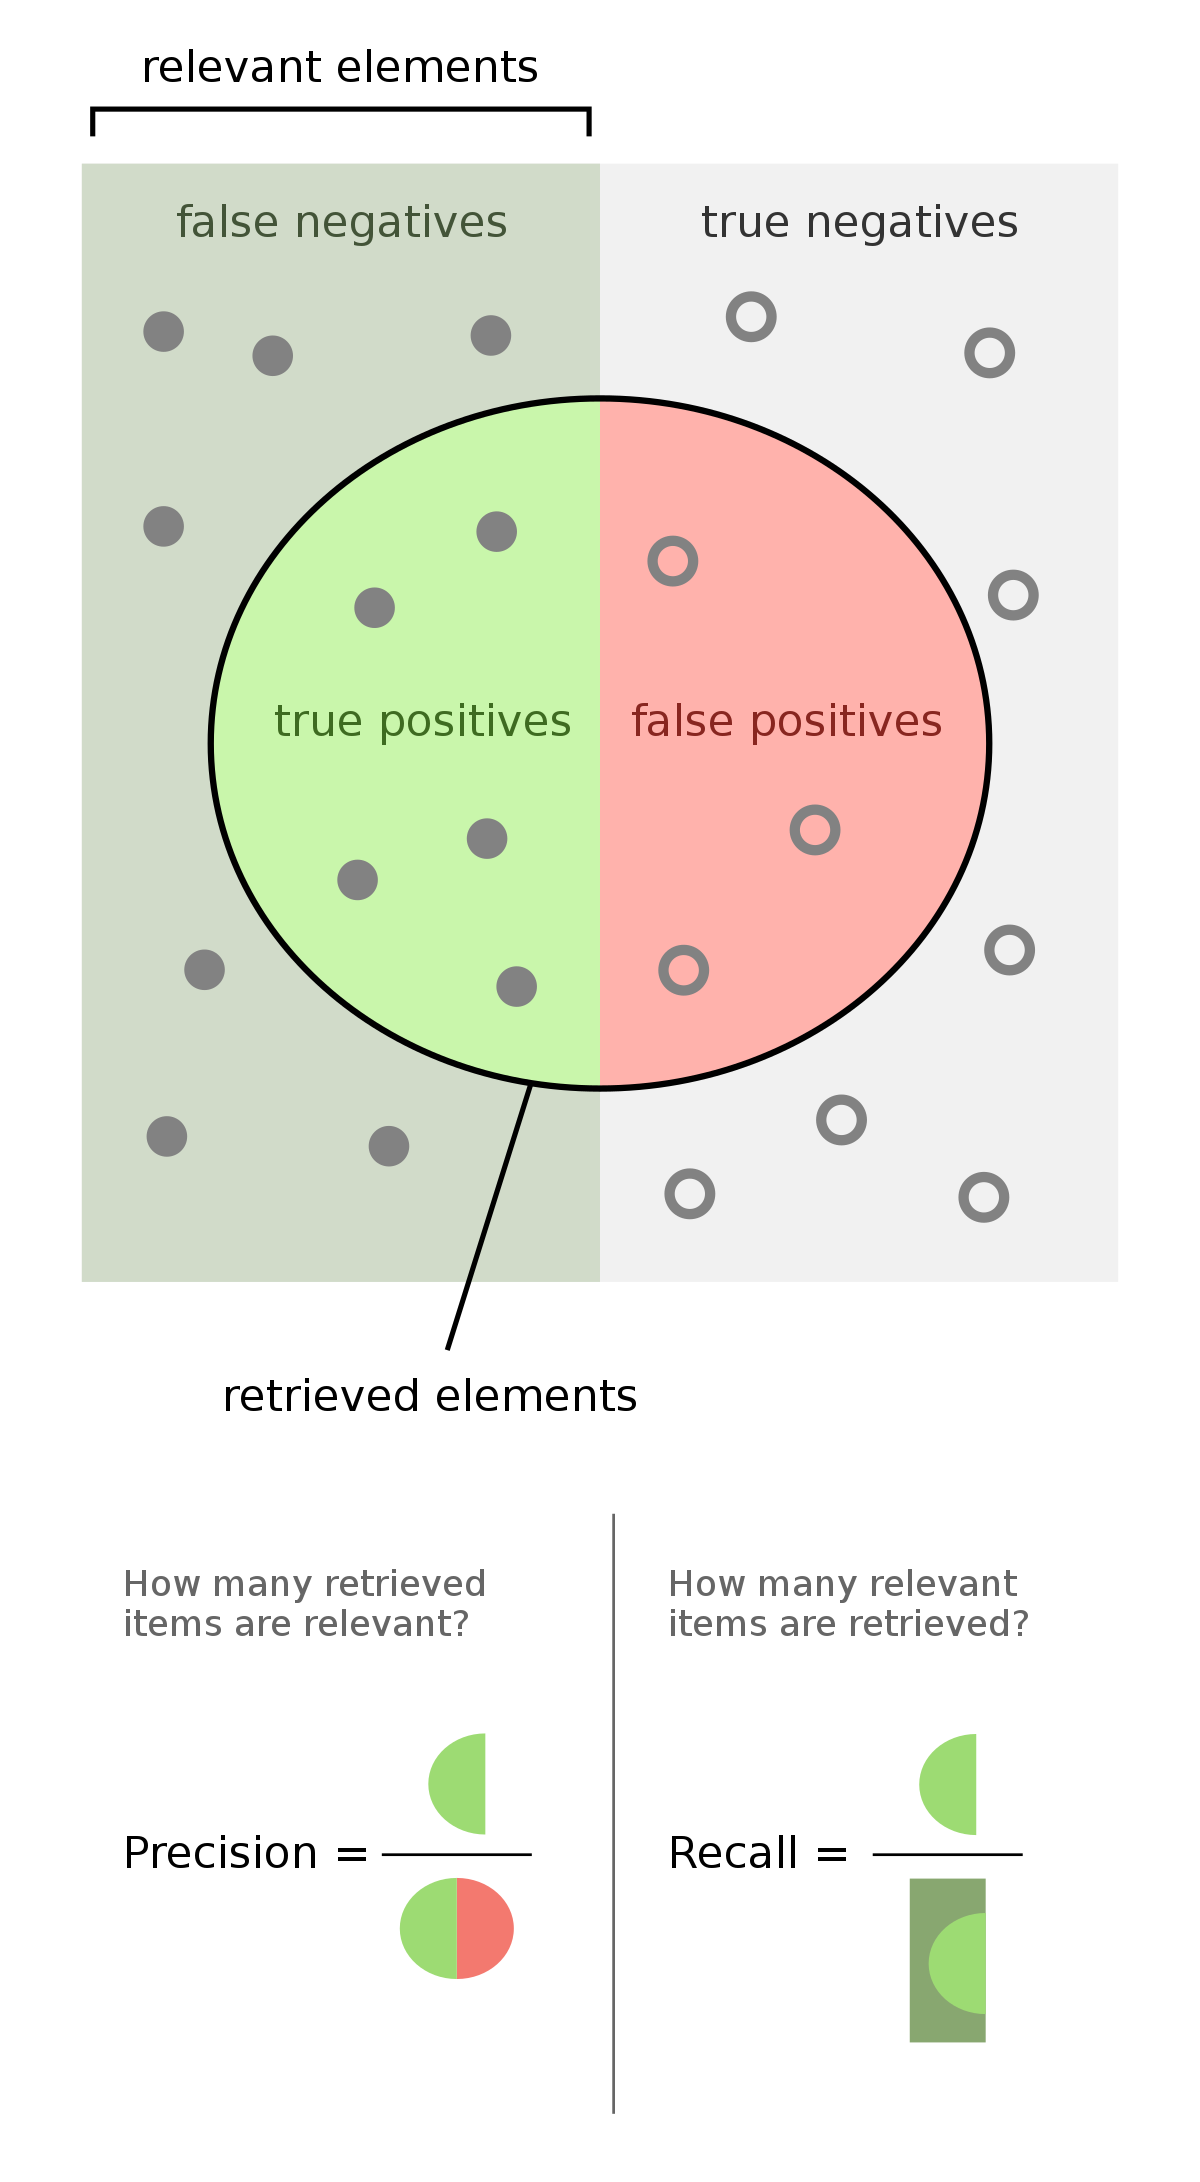

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
import string
import re
import os
import random
from tqdm import tqdm

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

import torch
from torch import nn
from torch import optim

%matplotlib inline

## Phân tích dữ liệu

Trước tiên, ta sử dụng pandas để load file csv

In [ ]:
# load dataset
train_df = pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
test_df = pd.read_csv('../input/quora-insincere-questions-classification/test.csv')
print("Train shape: ", train_df.shape)
print("Test shape: ", test_df.shape)

In [ ]:
train_df.head(5)

In [ ]:
train_target = train_df['target'].values
np.unique(train_target)

Về tổng quan, bộ dữ liệu huấn luyện gồm 3 cột:
* **qid**: ID của câu hỏi
* **question_text**: dữ liệu dạng chuỗi, là nội dung câu hỏi cần phân loại
* **target**: chỉ gồm 2 giá trị là 0 và 1, là kết quả cho thấy câu hỏi không chân thành (1) hoặc chân thành (0)

Trong đó, ta quan tâm đến 2 cột chính là "question_text" và "target"

Tập train gồm hơn 1,3 triệu câu hỏi và tập test gồm hơn 375 nghìn câu hỏi.

In [ ]:
print("Check for missing values in train set")
null_check=train_df.isnull().sum()
print(null_check)
print("Check for missing values in test set")
null_check=test_df.isnull().sum()
print(null_check)

Không có dữ liệu bị thiếu ở cả tập train và tập test, tức là không có ô nào trong bảng bị trống cả. Ta không cần xử lý những dữ liệu thiếu.

Ta kiểm tra phân bố dữ liệu của bộ dữ liệu huấn luyện

In [ ]:
target_0 = train_df.loc[train_df['target'] == 0].count()[0]
target_1 = train_df.loc[train_df['target'] == 1].count()[0]
colors = ['r', 'b']

plt.figure(figsize=(10,7))
plt.subplot(1, 2, 1)
plt.title('Question count')
bar = plt.bar(['Sincere', 'Insincere'], [target_0, target_1])

plt.subplot(1, 2, 2)
plt.title('Question percentage')
pie = plt.pie([target_0, target_1], labels=['Sincere', 'Insincere'], autopct='%.2f %%')
plt.show()

Số lượng câu hỏi không chân thành (Insincere) chỉ chiếm hơn 6% trong tổng số câu hỏi. Như vậy dữ liệu bị lệch rất nhiều, vì thế bài toán được đánh giá dựa trên F1 Score. Tập dữ liệu không cân bằng sẽ không ảnh hưởng đến điểm số.

Bây giờ, chúng ta sẽ phân tích một số thông số đặc trưng của bộ dữ liệu huấn luyện:

* Số lượng từ trong câu
* Số lượng từ chỉ xuất hiện 1 lần trong câu (unique words)
* Số lượng ký tự trong câu
* Số lượng stopwords trong câu (là các chữ như "a, an, the,...")
* Số lượng dấu câu trong câu ("?, ., !,...")
* Số lượng từ được viết hoa

In [ ]:
# Get stopwords from nltk lib
eng_stopwords = set(stopwords.words('english'))

In [ ]:
# Number of words in the text
train_df["num_words"] = train_df["question_text"].apply(lambda x: len(str(x).split()))

# Number of unique words in the text 
train_df["num_unique_words"] = train_df["question_text"].apply(lambda x: len(set(str(x).split())))

# Number of characters in the text
train_df["num_chars"] = train_df["question_text"].apply(lambda x: len(str(x)))

# Number of stopwords in the text 
train_df["num_stopwords"] = train_df["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

# Number of punctuations in the text
train_df["num_punctuations"] = train_df['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

# Number of upper case words in the text 
train_df["num_words_upper"] = train_df["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# Number of numbers in the text 
train_df['num_numbers'] = train_df['question_text'].apply(lambda x: sum(c.isdigit() for c in x))

In [ ]:
train_df.describe().apply(lambda x: x.apply('{:.2f}'.format))

Ta sử dụng thêm một số biểu đồ để trực quan hơn các đặc trưng

In [ ]:
#truncation for better visuals
train_df['num_words'].loc[train_df['num_words']>60] = 60 
train_df['num_punctuations'].loc[train_df['num_punctuations']>10] = 10
train_df['num_chars'].loc[train_df['num_chars']>350] = 350 

f, axes = plt.subplots(2, 3, figsize=(20,10))
sns.boxplot(x='target', y='num_words', data=train_df, ax=axes[0][0])
axes[0][0].set_title("Number of words")

sns.boxplot(x='target', y='num_unique_words', data=train_df, ax=axes[0][1])
axes[0][1].set_title("Number of unique words")

sns.boxplot(x='target', y='num_chars', data=train_df, ax=axes[0][2])
axes[0][2].set_title("Number of characters")

sns.boxplot(x='target', y='num_stopwords', data=train_df, ax=axes[1][0])
axes[1][0].set_title("Number of stopwords")

sns.boxplot(x='target', y='num_punctuations', data=train_df, ax=axes[1][1])
axes[1][1].set_title("Number of punctuations")

sns.boxplot(x='target', y='num_words_upper', data=train_df, ax=axes[1][2])
axes[1][2].set_title("Number of upper case words")
plt.show()

Nhận xét:
* Câu hỏi không chân thành có nhiều chữ cái, ký tự hơn.
* Có nhiều dấu câu, số và chữ viết hoa làm loãng dữ liệu, không giúp ích cho model để phân loại.

Bây giờ, ta sẽ phân tích tần suất của các n-grams xuất hiện nhiều trong bộ dữ liệu. (n-grams là một cụm từ cấu tạo bởi n từ)

Ở đây ta sẽ sử dụng CountVectorizer của thư viện sklearn. CountVectorizer có nhiệm vụ là vector hóa corpus (gán id cho các từ có mặt trong corpus) và biến đổi một chuỗi đầu vào thành ma trận số đếm dựa trên các từ có trong corpus. Như vậy ta có thể tận dụng CountVectorizer để đếm số n-grams bằng cách dùng corpus để vừa làm word vector và vừa làm chuỗi đầu vào cho CountVectorizer.

In [ ]:
# split into Insincere and Sincere classes
train1_df = train_df[train_df["target"]==1]
train0_df = train_df[train_df["target"]==0]

# n-grams count
def get_top_ngram(text, n=1):
    # make word vector from corpus
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(text)
    # corpus as input of CountVectorizer
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:50]

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(20, 15))
plt.suptitle("Unigram frequency", fontsize=20)

# uni-grams in Sincere class
top_uni_grams = get_top_ngram(train0_df['question_text'],n=1)
x,y = map(list,zip(*top_uni_grams))
sns.barplot(x=y,y=x,ax=axes[0])
axes[0].set_title("Sincere")

# uni-grams in Insincere class
top_uni_grams = get_top_ngram(train1_df['question_text'],n=1)
x,y = map(list,zip(*top_uni_grams))
sns.barplot(x=y,y=x,ax=axes[1])
axes[1].set_title("Insincere")
plt.show()

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(20, 15))
plt.suptitle("Bigram frequency", fontsize=20)

# bi-grams in Sincere class
top_bi_grams = get_top_ngram(train0_df['question_text'],n=2)
x,y = map(list,zip(*top_bi_grams))
sns.barplot(x=y,y=x,ax=axes[0])
axes[0].set_title("Sincere")

# bi-grams in Insincere class
top_bi_grams = get_top_ngram(train1_df['question_text'],n=2)
x,y = map(list,zip(*top_bi_grams))
sns.barplot(x=y,y=x,ax=axes[1])
axes[1].set_title("Insincere")
plt.show()

Nhận xét:

* Có những từ phổ biến ở cả 2 class như: 'people', 'like', 'think', 'year old', 'united states'... $\rightarrow$ Những từ này mang tính trung lập, không có mấy tác dụng để phân biệt
* Những từ chỉ phổ biến ở class Sincere: 'does', 'best', 'good',...
* Những từ chỉ phổ biến ở class Insincere: 'donald trump', 'women', 'men', 'white people', 'black people'... $\rightarrow$ Liên quan đến chính trị, phân biệt giới tính, phân biệt chủng tộc,...

Sử dụng wordcloud để dữ liệu thêm trực quan

In [ ]:
from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud(text, mask=None, max_words=100, max_font_size=100, figsize=(10.0,7.0), 
                   title=None, title_size=25):
    stopwords = set(STOPWORDS)
    
    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    plt.figure(figsize=figsize)
    plt.imshow(wordcloud);
    plt.title(title, fontdict={'size': title_size, 'color': 'black'})
    plt.axis('off')
    plt.show()
    
plot_wordcloud(train0_df['question_text'], title='Word Cloud of Sincere Questions')
plot_wordcloud(train1_df['question_text'], title='Word Cloud of Insincere Questions')

## Làm sạch dữ liệu

Từ những phân tích trên, ta cần làm sạch các ký tự như dấu câu, số đếm.

Bên cạnh đó, ta cần sửa lại những từ hay bị sai chính tả, những contraction (ví dụ như "aren't" là "are not").

Ta sẽ không sử dụng stemming (đưa từ về dạng gốc), không xóa các stopwords vì sẽ sử dụng pre-trained embedding.

Mispelling

In [ ]:
mispell_dict = {
    'grey': 'gray',
    'litre': 'liter',
    'labour': 'labor',
    'favour': 'favor',
    'colour': 'color',
    'centre': 'center',
    'honours': 'honor',
    'theatre': 'theater',
    'realise': 'realize',
    'defence': 'defense',
    'licence': 'license',
    'analyse': 'analyze',
    'practise': 'practice',
    'behaviour': 'behavior',
    'neighbour': 'neighbor',
    'recognise': 'recognize',
    'organisation':'organization',
    'Qoura': 'Quora',
    'quora': 'Quora',
    'Quorans': 'Quoran',
    'infty': 'infinity',
    'judgement': 'judge',
    'learnt': 'learn',
    'modelling': 'model',
    'cancelled': 'cancel',
    'travelled': 'travel',
    'travelling': 'travel',
    'aluminium': 'alumini',
    'counselling':'counseling',
    'cheque': 'bill',
    'upvote': 'agree',
    'upvotes': 'agree',
    'vape': 'cigarette',
    'jewellery': 'jewell',
    'Fiverr': 'freelance',
    'programd': 'program',
    'programme': 'program',
    'programr': 'programer',
    'programrs': 'programer',
    'WeChat': 'socialmedia',
    'Snapchat': 'socialmedia',
    'Redmi': 'cellphone',
    'Xiaomi': 'cellphone',
    'OnePlus': 'cellphone',
    'cryptos': 'crypto',
    'bitcoin': 'crypto',
    'Coinbase': 'crypto',
    'bitcoins': 'crypto',
    'ethereum': 'crypto',
    'Ethereum': 'crypto',
    'Blockchain': 'crypto',
    'blockchain': 'crypto',
    'cryptocurrency': 'crypto',
    'cryptocurrencies': 'crypto',
    '₹': 'rupee',
    'Brexit': 'Britain exit',
    'Paytm': 'Pay Through Mobile',
    'KVPY': 'Kishore Vaigyanik Protsahan Yojana',
    'GDPR': 'General Data Protection Regulation',
    'INTJ': 'Introversion Intuition Thinking Judgment',
    "ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because",
    "could've": "could have", "couldn't": "could not", "didn't": "did not", "doesn't": "does not",
    "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
    "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did",
    "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "i'd": "i would",
    "i'd've": "i would have", "i'll": "i will", "i'll've": "I will have", "i'm": "i am",
    "i've": "I have", "isn't": "is not", "it'd": "it would",
    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is",
    "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
    "mightn't": "might not", "mightn't've": "might not have", "must've": "must have",
    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
    "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not",
    "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have",
    "she'll": "she will", "she'll've": "she will have", "she's": "she is",
    "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
    "so've": "so have", "so's": "so as", "this's": "this is", "that'd": "that would",
    "that'd've": "that would have", "that's": "that is", "there'd": "there would",
    "there'd've": "there would have", "there's": "there is", "here's": "here is",
    "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
    "they'll've": "they will have", "they're": "they are", "they've": "they have",
    "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have",
    "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
    "weren't": "were not", "what'll": "what will", "what'll've": "what will have",
    "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is",
    "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have",
    "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
    "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not",
    "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
    "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
    "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will",
    "you'll've": "you will have", "you're": "you are", "you've": "you have", 'colour': 'color',
    'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling',
    'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor',
    'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize',
    'youtu ': 'youtube ', 'qoura': 'quora', 'sallary': 'salary', 'whta': 'what',
    'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
    'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doi': 'do I',
    'thebest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation',
    'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis',
    'etherium': 'ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017',
    '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess',
    "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization',
    'demonitization': 'demonetization', 'demonetisation': 'demonetization'
}

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = _get_mispell(mispell_dict)

def clean_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)

In [ ]:
# correct mispelling
train_df["question_text"] = train_df["question_text"].apply(lambda x: clean_misspell(x))
test_df["question_text"] = test_df["question_text"].apply(lambda x: clean_misspell(x))

Punctuations

In [ ]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '\xa0', '\t',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '\u3000', '\u202f',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '«',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

# replace puncts
def clean_puncts(text):
    text = str(text)
    for punct in "/-'":
        text = text.replace(punct, ' ')
    for punct in puncts:
        text = text.replace(punct, f' {punct} ')
    return text

In [ ]:
train_df["question_text"] = train_df["question_text"].apply(lambda x: clean_puncts(x))
test_df["question_text"] = test_df["question_text"].apply(lambda x: clean_puncts(x))

Numbers

In [ ]:
# replace numbers with "#"
def clean_numbers(text):
    text = re.sub('[0-9]{5,}', '#####', text)
    text = re.sub('[0-9]{4}', '####', text)
    text = re.sub('[0-9]{3}', '###', text)
    text = re.sub('[0-9]{2}', '##', text)
    return text

In [ ]:
train_df["question_text"] = train_df["question_text"].apply(lambda x: clean_numbers(x))
test_df["question_text"] = test_df["question_text"].apply(lambda x: clean_numbers(x))

In [ ]:
""" # Save dataset
train_df.to_csv('./train_fix.csv', index=False)
test_df.to_csv('./test_fix.csv', index=False)
"""

## Chuẩn bị dữ liệu

Để có thể đưa dữ liệu vào mô hình, ta cần một số bước:
* **tokenization**: Tách các câu trong corpus thành các token và gán id (một số tự nhiên) cho từng token. Một token ở đây là một từ. Như vậy, từ một câu văn sẽ được dịch thành một dãy các số tự nhiên - là dãy các id của từ có mặt trong câu.
* **padding**: Thêm các ô trống vào đầu câu để các câu trong corpus có cùng độ dài.
* **word embedding**: Mã hóa các word thành một vector số thực để model có thể xử lý được. Giống như một cuốn từ điển của model, dịch từ các word id sang các vector số thực mà model có thể hiểu. Sau quá trình huấn luyện, lớp embedding có thể học được các ngữ nghĩa của từ, các từ gần nghĩa nhau sẽ có vector giá trị gần giống nhau.

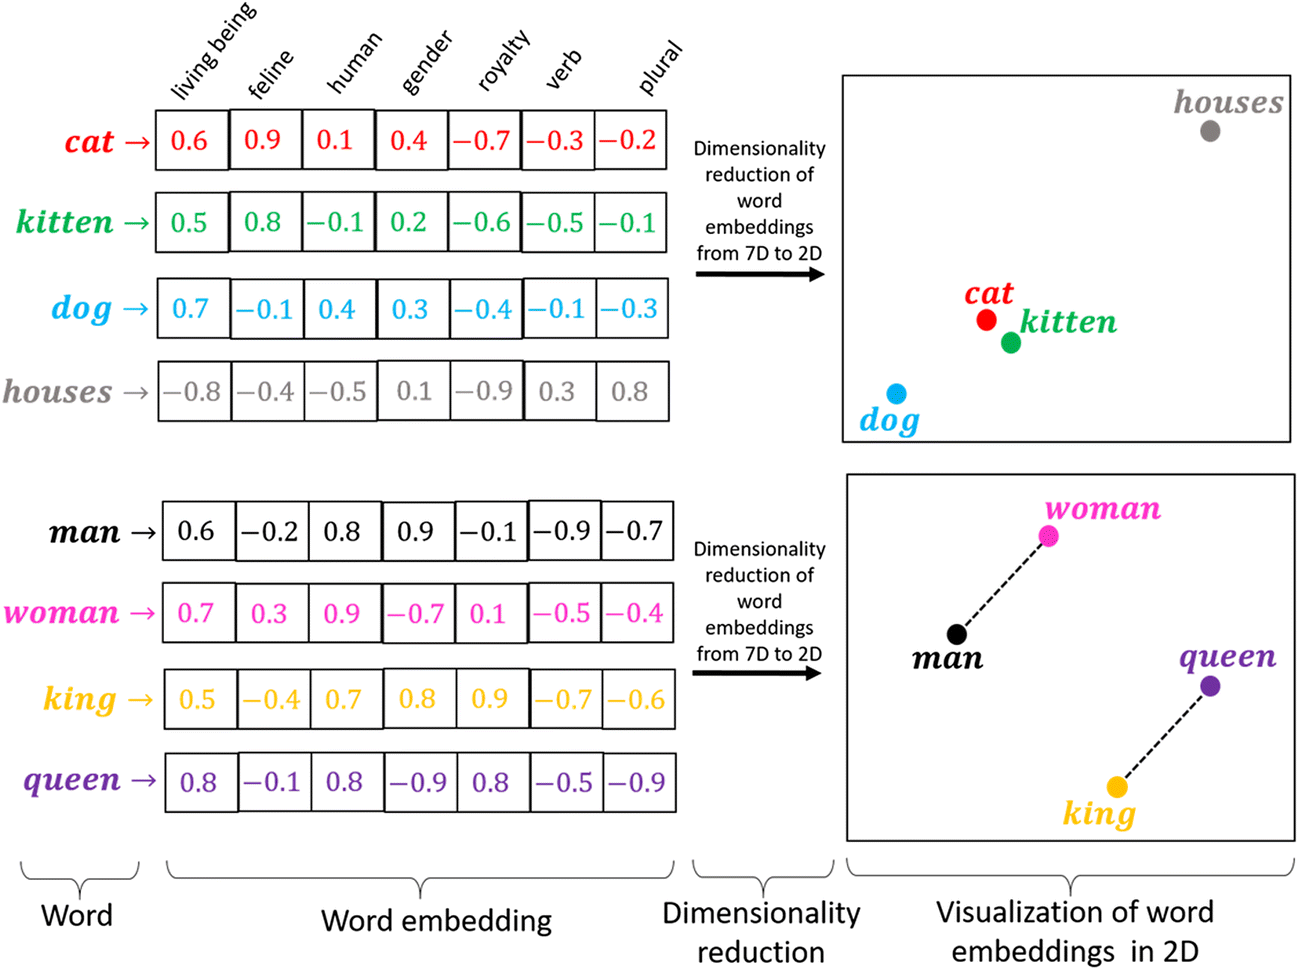

In [ ]:
""" # Load dataset
train_df = pd.read_csv('./train_fix.csv')
test_df = pd.read_csv('./test_fix.csv')
print("Train shape: ", train_df.shape)
print("Test shape: ", test_df.shape)
"""

Hyperparams

In [ ]:
embed_size = 300 # how big is each word vector
max_features = 120000 # how many unique words to use
maxlen = 72 # max number of words in a question to use
hidden_size = 64  # models hidden_size
n_splits = 5   # number of folds in k-fold cv
N_REPEATS = 3  # number of repeats

batch_size = 512
train_epochs = 5

SEED = 1029

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

### Tokenizer and padding

In [ ]:
train_X = train_df["question_text"].values
test_X = test_df["question_text"].values

# Tokenize the corpus of both train and test set
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

# Pad the sentences of both train and test set
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

## Get the target values
train_y = train_df['target'].values

### Pre-trained Embeddings

Thay vì phải học cách mã hóa các word id sang các vector từ đầu, ta tận dụng các word embedding đã được train sẵn mà đề bài cung cấp. Điều này cũng giúp cải thiện được performance và giảm được thời gian training của model.

Load bộ embeddings từ file zip

In [ ]:
from zipfile import ZipFile

zip_file = ZipFile('../input/quora-insincere-questions-classification/embeddings.zip', 'r')
zip_file.namelist()

Đề bài cung cấp các bộ pre-trained embedding: glove, paragram, fasttext (wiki-news) và word2vec (GoogleNews). Ở đây ta sẽ sử dụng 3 bộ: glove, fasttext và paragram.

In [ ]:
zip_file.extractall()
glove_path = './glove.840B.300d/glove.840B.300d.txt'
paragram_path =  './paragram_300_sl999/paragram_300_sl999.txt'
wiki_news_path = './wiki-news-300d-1M/wiki-news-300d-1M.vec'

In [ ]:
# load embedding functions taken from https://www.kaggle.com/gmhost/gru-capsule
def load_glove(word_index):
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(glove_path))

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 

def load_fasttext(word_index):
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(wiki_news_path) if len(o)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector

    return embedding_matrix

def load_para(word_index):
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(paragram_path, encoding="utf8", errors='ignore') if len(o)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

Thay vì chỉ sử dụng một bộ embedding, ta trộn các bộ embedding lại với nhau (lấy giá trị trung bình của các embedding). Em đã thử nghiệm và nhận thấy khi trộn các bộ embedding thì kết quả tốt hơn là chỉ sử dụng riêng một bộ embedding.

In [ ]:
# load pre-trained embeddings and blend them
glove_embedding = load_glove(tokenizer.word_index)
fasttext_embedding = load_fasttext(tokenizer.word_index)
para_embedding = load_para(tokenizer.word_index)
embedding_matrix = np.mean([glove_embedding, fasttext_embedding, para_embedding], axis = 0)

### Stratified K-fold cross-validation cho tập dữ liệu huấn luyện

**K-fold cross-validation**: Thực hiện việc trộn dataset và chia bộ dataset thành K nhóm (fold), sau đó thực hiện lặp K lần. Ở mỗi vòng lặp, ta chọn không hoàn lại 1 nhóm để làm tập valid và (K-1) nhóm còn lại để làm tập train. Model được khởi tạo lại đầu mỗi vòng lặp. Ta giữ lại kết quả dự đoán của model ở từng fold và cuối cùng tính trung bình dự đoán ở các fold.

**Stratified K-fold cross-validation**: Khi chia bộ dataset, mỗi fold sẽ có tỉ lệ giữa các class giống với tỉ lệ ở dataset ban đầu. Được sử dụng khi tỉ lệ giữa các class quá lệch trong bộ dataset.

In [ ]:
kfold = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED).split(train_X, train_y))

In [ ]:
# solution to ensure determinism in the results. From https://www.kaggle.com/hengzheng/pytorch-starter
def seed_torch(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

## Mô hình

Vì dữ liệu là dạng chuỗi, nên ta sẽ sử dụng **mạng nơ-ron hồi quy (Recurrent Neural Network - RNN)**.

Mạng RNN là một loại mạng trong đó hidden state từ bước trước (mô tả ngữ cảnh của chuỗi đến thời điểm đó) làm đầu vào cho bước hiện tại. Nhưng mạng RNN có điểm yếu là không mô tả học được chuỗi quá dài do hiện tượng vanishing gradient. Mạng LSTM khắc phục phần nào nhược điểm này bằng cách cho phép thông tin lan truyền trực tiếp hơn thông qua một biến trạng thái ô (cell state). 

Và để học được ngữ cảnh 2 chiều trong câu, tức là nhìn vào cả quá khứ và tương lai của từ hiện tại, ta sử dụng mạng **Bidirectional LSTM**. Ngoài ra, để học được các biểu diễn trừu tượng hơn, ta trồng các tầng BiLSTM lên nhau.

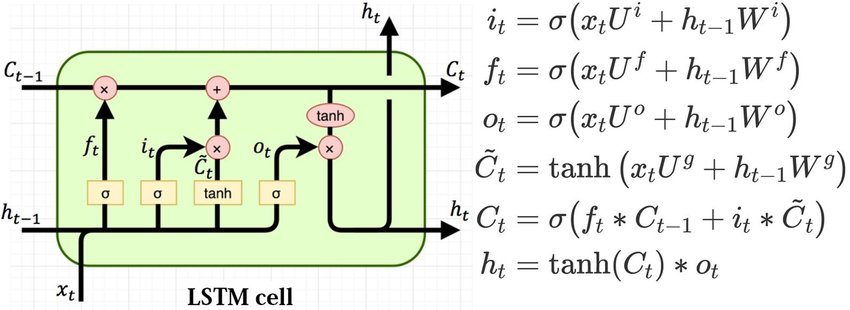

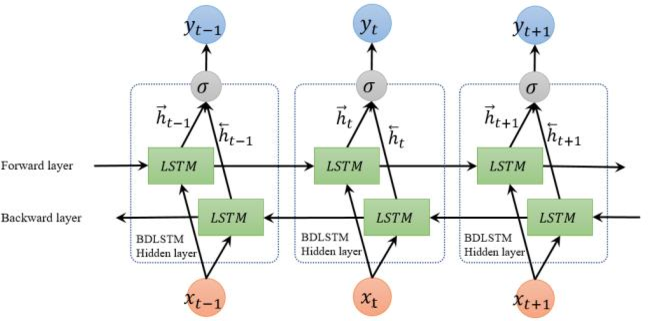

Bài toán là binary classification nên ta sẽ sử dụng một output nơ-ron ở lớp cuối cùng để lấy kết quả từ LSTM và đưa ra một giá trị logits, sau đó đưa qua hàm sigmoid để nhận được kết quả phân lớp cuối cùng. Ở đây chỉ lấy hidden state cuối của LSTM để làm kết quả để phân lớp.

Ta thêm một lớp MLP trước khi đưa kết quả vào lớp output.

**Kiến trúc của mô hình**

* **Embedding layer** là bộ pre-trained embedding được đóng băng (không được cập nhật). Đầu ra có sử dụng Dropout để tránh overfit.
* **BiLSTM layer** với 2 tầng và mỗi tầng 128 units.
* **Mạng MLP** với hàm kích hoạt là ReLU, có sử dụng Batchnorm và Dropout.

Ta skip hàm sigmoid ở lớp cuối cùng vì sẽ sử dụng hàm loss là BCEWithLogitsLoss(), hàm này đã cài đặt sigmoid sẵn sau đó tính BCE, tận dụng được trick cài đặt với số mũ $e$ nên kết quả sẽ ổn định hơn.

In [ ]:
class BiLSTM(nn.Module):
    def __init__(self, num_layer=2, output_size=1):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        
        # Freeze embedding layer
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = nn.Dropout2d(0.2)
        # Modules
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layer, batch_first=True, bidirectional=True)
        
        self.linear = nn.Linear(hidden_size*2, 32)
        self.batchnorm = nn.BatchNorm1d(num_features=32)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(32, output_size)
        # Skip sigmoid() because using BCEWithLogitsLoss() function

    def forward(self, input):
        # word embedding
        x = self.embedding(input)   # batch_size x sentence_len x embed_size
        x = torch.squeeze(self.embedding_dropout(torch.unsqueeze(x, 0)))
        # LSTM
        h, _ = self.lstm(x)       # batch_size x sentence_len x hidden_size*2
        # take the last hidden state only
        out = self.linear(h[:, -1, :])  # batch_size x sentence_len x 1
        out = self.batchnorm(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc(out)
        return out

## Huấn luyện mô hình

**Chiến thuật huấn luyện**
* **Stratified K-Fold Cross Validation**
* Sử dụng **DataLoader** của pytorch để load dữ liệu vào theo các batch
* **Loss function: BCEWithLogitsLoss()** - cài đặt cả sigmoid và hàm BCE loss
* **Optimizer: Adam** với learning rate là 0.001.
* **Averaging over multiple seeds**: Lặp lại nhiều lần huấn luyện với các SEED khác nhau. Sau đó lấy giá trị trung bình của các kết quả dự đoán để làm kết quả dự đoán cuối cùng. Việc này giúp cho model tránh bị overfit vào dữ liệu trong 1 lần train.

In [ ]:
x_test_cuda = torch.tensor(test_X, dtype=torch.long).to(device)
test = torch.utils.data.TensorDataset(x_test_cuda)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

test_preds_models = []
train_preds_models = []
train_losses_models = []
val_losses_models = []

for rep_idx in range(N_REPEATS):
    # TODO: loop for each repeat
    print(f'Repeat {rep_idx + 1}')
    # change seed after each repeat
    seed_torch(SEED + rep_idx)
    train_losses = []
    val_losses = []
    train_preds = np.zeros((len(train_X)))
    test_preds = np.zeros((len(test_X)))
    for i_fold, (train_idx, valid_idx) in enumerate(kfold):
        # TODO: loop for each fold
        x_train_fold = torch.tensor(train_X[train_idx], dtype=torch.long).to(device)
        y_train_fold = torch.tensor(train_y[train_idx, np.newaxis], dtype=torch.float32).to(device)
        x_val_fold = torch.tensor(train_X[valid_idx], dtype=torch.long).to(device)
        y_val_fold = torch.tensor(train_y[valid_idx, np.newaxis], dtype=torch.float32).to(device)
        # model initialize
        model = BiLSTM().to(device)
        # loss func and optimizer define
        loss_fn = torch.nn.BCEWithLogitsLoss(reduction="sum")
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        # dataloader
        train = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
        valid = torch.utils.data.TensorDataset(x_val_fold, y_val_fold)
        train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
        valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

        print(f'Fold {i_fold + 1}')

        for epoch in range(train_epochs):
            # TODO: loop for each epoch
            ## TRAIN
            model.train()
            avg_loss = 0.
            for x_batch, y_batch in tqdm(train_loader, disable=True):
                # forward
                y_pred = model(x_batch)
                # compute BCE loss
                loss = loss_fn(y_pred, y_batch)
                # zero the gradient 
                optimizer.zero_grad()
                # backward and update params
                loss.backward()
                optimizer.step()
                avg_loss += loss.item() / len(train_loader)
            
            ## VALID
            model.eval()
            valid_preds_fold = np.zeros((x_val_fold.size(0)))
            test_preds_fold = np.zeros(len(test_X))
            avg_val_loss = 0.
            for i, (x_batch, y_batch) in enumerate(valid_loader):
                y_pred = model(x_batch).detach()
                avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
                valid_preds_fold[i * batch_size:(i+1) * batch_size] = torch.sigmoid(y_pred.cpu())[:, 0]

            print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}'.format(
                epoch + 1, train_epochs, avg_loss, avg_val_loss))
            train_losses.append(avg_loss)
            val_losses.append(avg_val_loss)
        
        # predictions for test set
        for i, (x_batch,) in enumerate(test_loader):
            y_pred = model(x_batch).detach()
            test_preds_fold[i * batch_size:(i+1) * batch_size] = torch.sigmoid(y_pred.cpu())[:, 0]

        train_preds[valid_idx] = valid_preds_fold
        test_preds += test_preds_fold / len(kfold)
        train_losses_models.append(train_losses)
        val_losses_models.append(val_losses)
    test_preds_models.append(test_preds)
    train_preds_models.append(train_preds)

Biểu đồ loss trong quá trình huấn luyện

In [ ]:
train_loss_arr = []
val_loss_arr = []
train_losses = np.array(train_losses_models)
val_losses = np.array(val_losses_models)
# Average loss among repeats
train_losses = np.mean(np.column_stack(train_losses), axis = 1)
val_losses = np.mean(np.column_stack(val_losses), axis = 1)

# The error would be the average loss of each epoch over K-folds
for i in range(train_epochs):
    train_loss_arr.append(train_losses[i::train_epochs].mean(axis=0))
    val_loss_arr.append(val_losses[i::train_epochs].mean(axis=0))

# Models loss plot
train_loss_arr = np.array(train_loss_arr)
val_loss_arr = np.array(val_loss_arr)
plt.plot(train_loss_arr, label='train loss')
plt.plot(val_loss_arr, label='val loss')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

Trong đó, giá trị loss là trung bình loss của các lần lặp.

Sau khi mô hình đã được huấn luyện, ta tìm threshold mà model có F1 score tốt nhất (đối với tập train).

In [ ]:
def threshold_search(y_true, y_proba):
    best_threshold = 0
    best_score = 0
    for threshold in tqdm([i * 0.01 for i in range(100)]):
        score = f1_score(y_true=y_true, y_pred=y_proba > threshold)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result

Lấy trung bình của các dự đoán giữa những lần lặp để làm kết quả dự đoán.

In [ ]:
# average of repeats on train set
train_predictions = np.mean(np.column_stack(train_preds_models), axis = 1)
# search for best thresh hold - highest f1 score on train set
search_result = threshold_search(train_y, train_predictions)
search_result

Tương tự, ta lấy trung bình của các dự đoán giữa những lần lặp lại để làm kết quả dự đoán trên tập test. Sau đó nộp bài.

In [ ]:
# average of repeats
test_predictions = np.mean(np.column_stack(test_preds_models), axis = 1)
# submission
sub = pd.read_csv('../input/quora-insincere-questions-classification/sample_submission.csv')
sub.prediction = test_predictions > search_result['threshold']
sub.to_csv("submission.csv", index=False)

Ways to improve the score:
- Use some Statistical features for training model
- Find better threshold search strategy
- Fine-tuning pre-trained models: BERT, ELECTRA, etc. (but it violates the rule of competition: no using external data)
- Data augment